In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import itertools
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split, cross_val_predict, TimeSeriesSplit, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Load and save data

In [2]:
# Upload the dataframe and fill null values with zero
df = pd.read_csv('../data/interim/airports.csv', index_col=0)
df = df.fillna(0)
df.head()

# Save df for later upload
df.to_csv('../data/processed/airports_processed.csv')

In [3]:
# Confirm no null values
df.isna().any().sum()

0

In [4]:
# Any duplicates?
df.duplicated().any()

False

# Visualize SFO Time Series

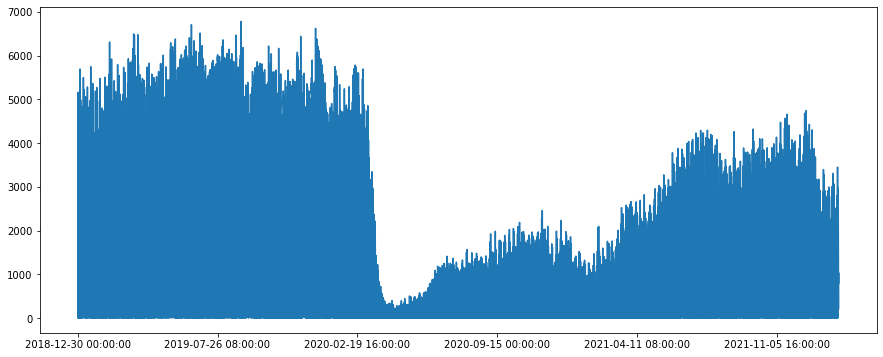

In [7]:
# Visualize SFO Time Series
df.SFO.plot(figsize=(15,6));

In [8]:
# Decompose and visualize the components SFO time series
decomposition = seasonal_decompose(df.SFO, period=24)

# Plot different components
fig = plt.figure()  
fig = decomposition.plot();  
fig.set_size_inches(8, 16)

# Base model 

276.0974183583407


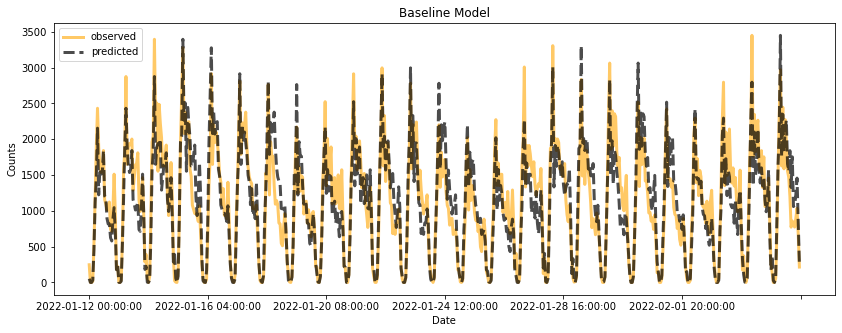

In [8]:
# Base model using yesterday's data
base_model_prediction = df.SFO.shift(24)

# Calculate mean error
error = (df.SFO-base_model_prediction).dropna()
print(sum(abs(error))/len(error))

# Plot observed and predicted values
ax = df.SFO.iloc[-500:].plot(label='observed', figsize=(14,5), linewidth = 3, color='orange', alpha=0.6)
base_model_prediction[-500:].plot(ax = ax, label='predicted', linewidth=3, color='black', linestyle='--')
ax.set_title('Baseline Model')
ax.set_xlabel('Date')
ax.set_ylabel('Counts')
ax.legend()

plt.show()

# Test for stationarity and seasonality

In [6]:
def test_stationarity(timeseries):
    '''Tests for trend stationarity using AD Fuller test and
    plots rolling mean and standard deviation over original data'''
    
    #Determe rolling mean and standard deviation
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

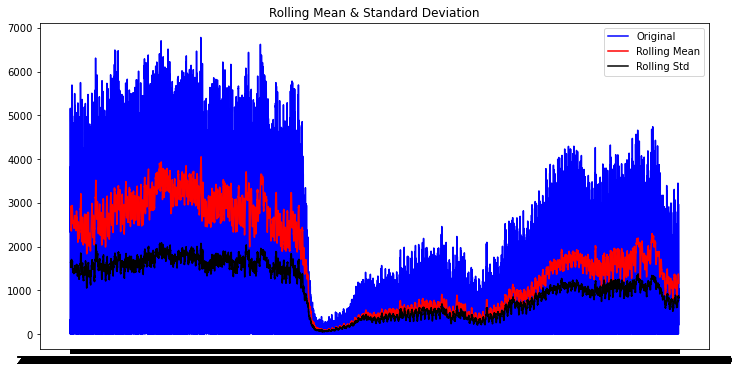

Results of Dickey-Fuller Test:
Test Statistic                    -3.123940
p-value                            0.024831
#Lags Used                        49.000000
Number of Observations Used    27166.000000
Critical Value (1%)               -3.430591
Critical Value (5%)               -2.861646
Critical Value (10%)              -2.566827
dtype: float64


In [6]:
# Test original SFO data for stationarity
test_stationarity(df.SFO)

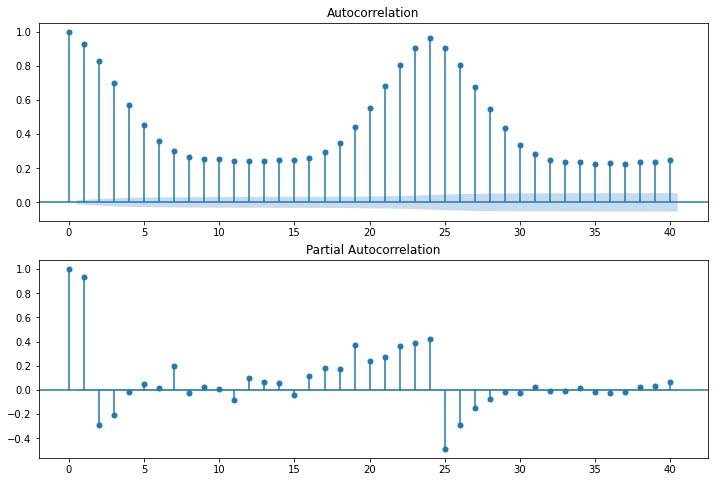

In [12]:
# Autocorrelation and Partial Autocorrelation Plots for original timeseries for SFO
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.SFO.dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.SFO.dropna(), lags=40, ax=ax2)

The autocorrelation plot decays slowly. The series is not stationary.

Seasonality with period 24

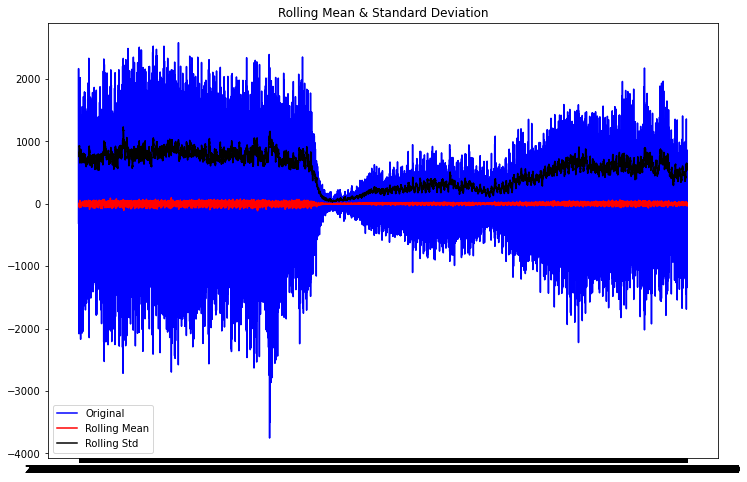

Results of Dickey-Fuller Test:
Test Statistic                   -36.546992
p-value                            0.000000
#Lags Used                        49.000000
Number of Observations Used    27165.000000
Critical Value (1%)               -3.430591
Critical Value (5%)               -2.861646
Critical Value (10%)              -2.566827
dtype: float64


In [13]:
# Take first difference and test for stationarity
df['first_difference']=df.loc[:,'SFO'] - df.loc[:,'SFO'].shift(1)
test_stationarity(df.first_difference.dropna())

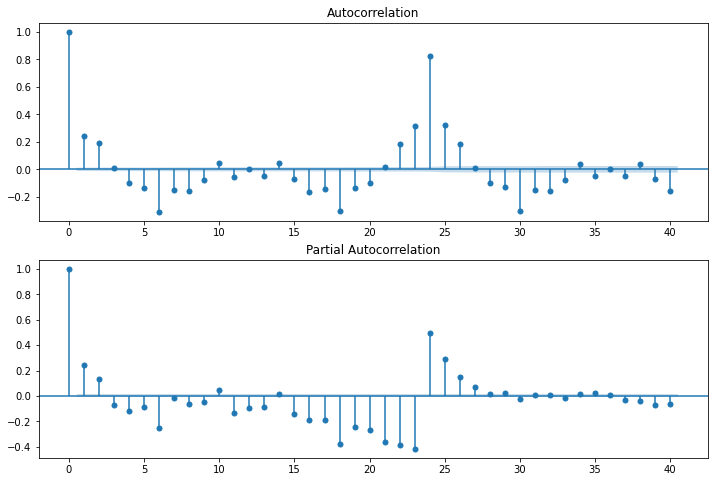

In [14]:
# Autocorrelation and Partial Autocorrelation Plots for first differenced timeseries for SFO
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.first_difference.dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.first_difference.dropna(), lags=40, ax=ax2)

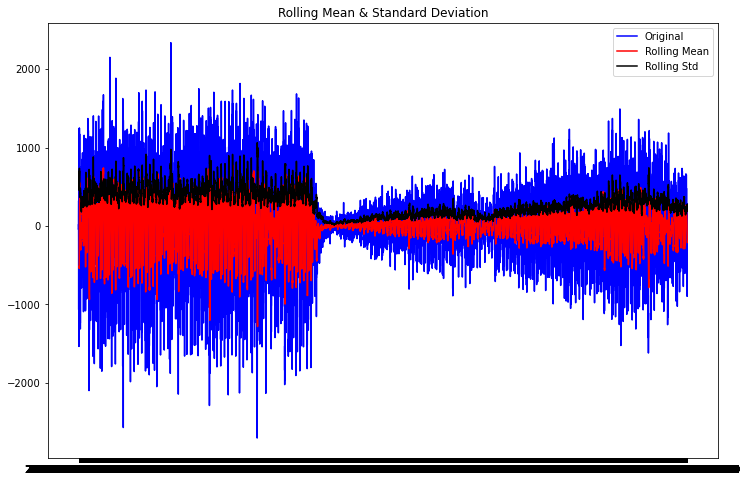

Results of Dickey-Fuller Test:
Test Statistic                   -32.831917
p-value                            0.000000
#Lags Used                        49.000000
Number of Observations Used    27142.000000
Critical Value (1%)               -3.430591
Critical Value (5%)               -2.861646
Critical Value (10%)              -2.566827
dtype: float64


In [19]:
# Take seasonal difference and test for stationarity
df['seasonal_difference']=df.SFO - df.SFO.shift(24)
test_stationarity(df.seasonal_difference.dropna())

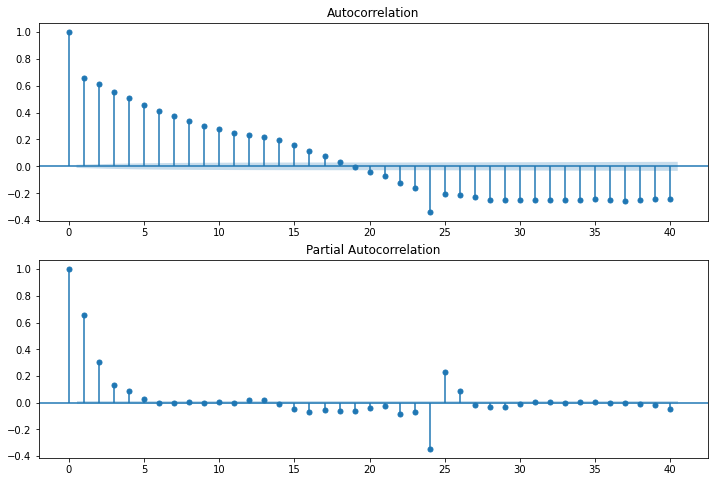

In [20]:
# Autocorrelation and Partial Autocorrelation Plots for seasonally differenced timeseries for SFO
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.seasonal_difference.dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.seasonal_difference.dropna(), lags=40, ax=ax2)

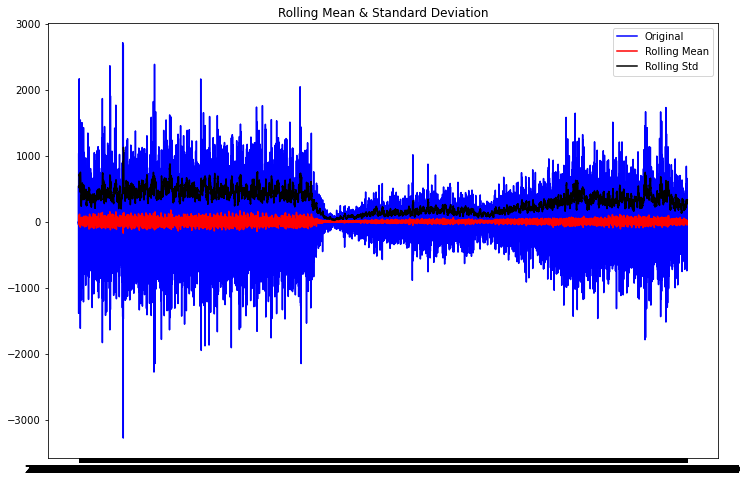

Results of Dickey-Fuller Test:
Test Statistic                   -40.758452
p-value                            0.000000
#Lags Used                        49.000000
Number of Observations Used    27141.000000
Critical Value (1%)               -3.430591
Critical Value (5%)               -2.861646
Critical Value (10%)              -2.566827
dtype: float64


In [21]:
# Take first difference and seasonal difference and test for stationarity
df['seasonal_first_difference'] = df.first_difference - df.first_difference.shift(24)
test_stationarity(df.seasonal_first_difference.dropna())

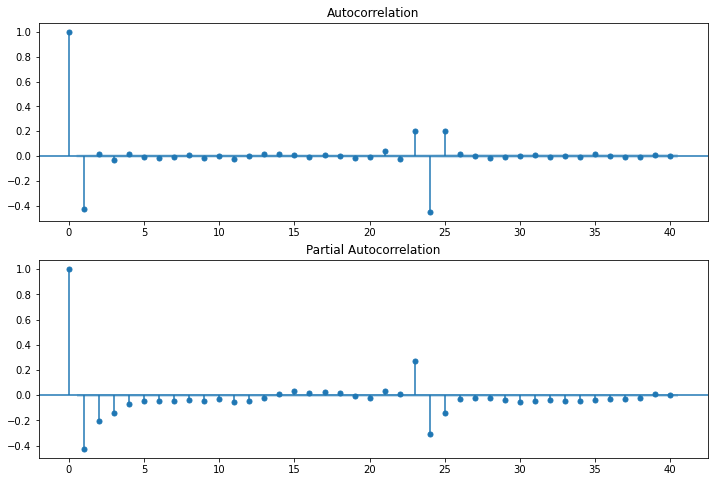

In [22]:
# Autocorrelation and Partial Autocorrelation Plots for first and seaonal first differenced timeseries for SFO
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.seasonal_first_difference.dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.seasonal_first_difference.dropna(), lags=40, ax=ax2)

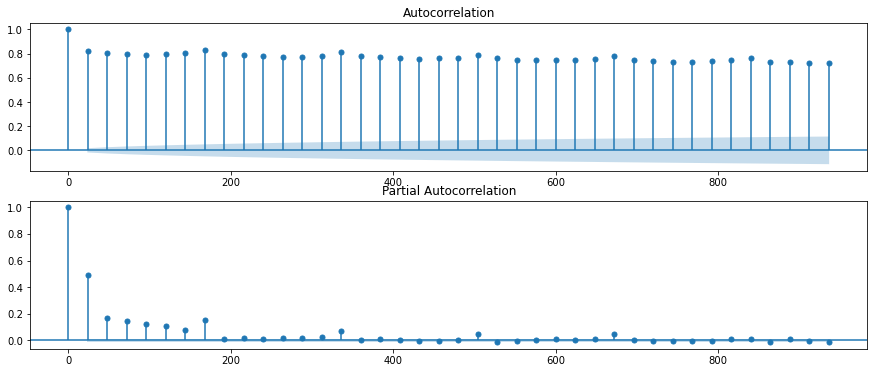

In [25]:
# Seasonal autocorrelation for first differenced series
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,6))
lags=[l*24 for l in range(40)]
sm.graphics.tsa.plot_acf(df.first_difference.dropna(),  lags=lags, ax=ax1)
sm.graphics.tsa.plot_pacf(df.first_difference.dropna(), lags=lags, ax=ax2)
plt.show()

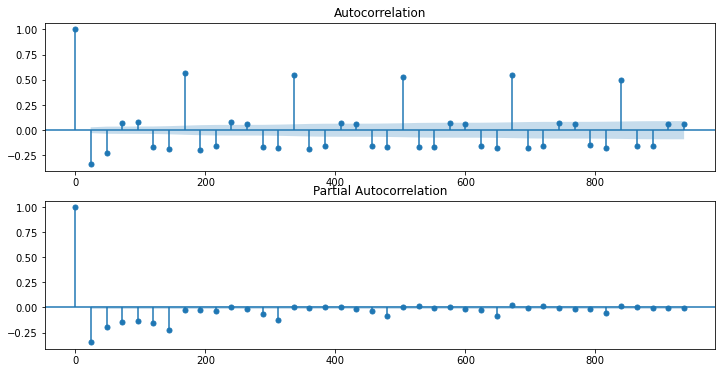

In [23]:
# Seasonal autocorrelation for seasonally adjusted series
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,6))
lags=[l*24 for l in range(40)]
sm.graphics.tsa.plot_acf(df.seasonal_difference.dropna(),  lags=lags, ax=ax1)
sm.graphics.tsa.plot_pacf(df.seasonal_difference.dropna(), lags=lags, ax=ax2)
plt.show()

/Users/shaghayeghroshan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


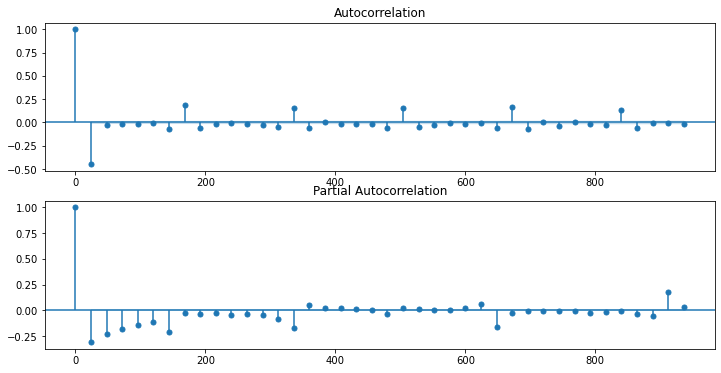

In [24]:
# Seasonal autocorrelation for seasonally differenced series
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,6))
lags=[l*24 for l in range(40)]
sm.graphics.tsa.plot_acf(df.seasonal_first_difference.dropna(),  lags=lags, ax=ax1)
sm.graphics.tsa.plot_pacf(df.seasonal_first_difference.dropna(), lags=lags, ax=ax2)
plt.show()

In [5]:
df.index = pd.to_datetime(df.index)

In [6]:
df_tr, df_ts = df.iloc[:-500], df.iloc[-500:]

In [7]:
def evaluate_model(data, column, order, seasonal_order, n_splits=3, 
                   max_train_size=10000, test_size=1000, dynamic=False):
    
    tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=max_train_size, test_size=test_size)
    mae = []
    
    for train_index, test_index in tscv.split(data):
        train, test = data.reset_index().loc[train_index], data.reset_index().loc[test_index]
        
        model = SARIMAX(train[column], order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=0)
        
        pred = model_fit.get_prediction(start=test.index.values[0], end = test.index.values[-1], dynamic=dynamic)
        pred_ci = pred.conf_int()
    
        mae.append(mean_absolute_error(test[column], pred.predicted_mean))

    cv_error = np.mean(mae)
    aic_avg = np.mean(model_fit.aic)
    
    return cv_error, aic_avg

In [8]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 3)
d = range(0,2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of p, q and q triplets and seasonal P, D, Q n n
P = Q = range(0, 4)
D = [1]
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(P, D, Q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[15]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 1, 1, 24)
SARIMAX: (0, 0, 1) x (0, 1, 2, 24)
SARIMAX: (0, 1, 0) x (3, 1, 3, 24)


In [9]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def grid_search(data, column, order, seasonal_order, dynamic=False):
    best_score, best_cfg, best_scfg=float('inf'), None, None
    for params in order:
        for seasonal_params in seasonal_order:
            try:
                mae, aic = evaluate_model(data, column, params, seasonal_params, dynamic=dynamic)
                if aic < best_score:
                    best_score, best_cfg, best_scfg = aic, params, seasonal_params
                print('ARIMA: {} X {}, MEAN AIC = {}'.format(params, seasonal_params, round(aic)))
            except:
                continue
    return print('Best ARIMA: {} X {}, MEAN AIC = {}'.format(best_cfg, best_scfg, best_score))

In [ ]:
# Find the optimum ARIMA parameters
grid_search(df_tr, 'SFO', pdq, seasonal_pdq)

ARIMA: (0, 0, 0) X (0, 1, 0, 24), MEAN AIC = 142018
ARIMA: (0, 0, 0) X (0, 1, 1, 24), MEAN AIC = 138433
ARIMA: (0, 0, 0) X (0, 1, 2, 24), MEAN AIC = 138011
ARIMA: (0, 0, 0) X (0, 1, 3, 24), MEAN AIC = 137820
ARIMA: (0, 0, 0) X (1, 1, 0, 24), MEAN AIC = 141081
ARIMA: (0, 0, 0) X (1, 1, 1, 24), MEAN AIC = 138156
ARIMA: (0, 0, 0) X (1, 1, 2, 24), MEAN AIC = 137868
ARIMA: (0, 0, 0) X (1, 1, 3, 24), MEAN AIC = 137591
ARIMA: (0, 0, 0) X (2, 1, 0, 24), MEAN AIC = 139611
ARIMA: (0, 0, 0) X (2, 1, 1, 24), MEAN AIC = 137801
ARIMA: (0, 0, 0) X (2, 1, 2, 24), MEAN AIC = 137530
ARIMA: (0, 0, 0) X (2, 1, 3, 24), MEAN AIC = 136779
ARIMA: (0, 0, 0) X (3, 1, 0, 24), MEAN AIC = 139177
ARIMA: (0, 0, 0) X (3, 1, 1, 24), MEAN AIC = 137798
ARIMA: (0, 0, 0) X (3, 1, 2, 24), MEAN AIC = 137734
ARIMA: (0, 0, 0) X (3, 1, 3, 24), MEAN AIC = 136613
ARIMA: (0, 0, 1) X (0, 1, 0, 24), MEAN AIC = 139688
ARIMA: (0, 0, 1) X (0, 1, 1, 24), MEAN AIC = 135601
ARIMA: (0, 0, 1) X (0, 1, 2, 24), MEAN AIC = 135375
ARIMA: (0, 0

ARIMA: (1, 1, 0) X (3, 1, 2, 24), MEAN AIC = 133425
ARIMA: (1, 1, 0) X (3, 1, 3, 24), MEAN AIC = 133892
ARIMA: (1, 1, 1) X (0, 1, 0, 24), MEAN AIC = 137066
ARIMA: (1, 1, 1) X (0, 1, 1, 24), MEAN AIC = 132506
ARIMA: (1, 1, 1) X (0, 1, 2, 24), MEAN AIC = 132396
ARIMA: (1, 1, 1) X (0, 1, 3, 24), MEAN AIC = 132379
ARIMA: (1, 1, 1) X (1, 1, 0, 24), MEAN AIC = 135296
ARIMA: (1, 1, 1) X (1, 1, 1, 24), MEAN AIC = 132409
ARIMA: (1, 1, 1) X (1, 1, 2, 24), MEAN AIC = 132390
ARIMA: (1, 1, 1) X (1, 1, 3, 24), MEAN AIC = 132302
ARIMA: (1, 1, 1) X (2, 1, 0, 24), MEAN AIC = 134405
ARIMA: (1, 1, 1) X (2, 1, 1, 24), MEAN AIC = 132366
ARIMA: (1, 1, 1) X (2, 1, 2, 24), MEAN AIC = 132413
ARIMA: (1, 1, 1) X (2, 1, 3, 24), MEAN AIC = 132998
ARIMA: (1, 1, 1) X (3, 1, 0, 24), MEAN AIC = 133870
ARIMA: (1, 1, 1) X (3, 1, 1, 24), MEAN AIC = 132316
ARIMA: (1, 1, 1) X (3, 1, 2, 24), MEAN AIC = 132359
ARIMA: (1, 1, 1) X (3, 1, 3, 24), MEAN AIC = 132723
ARIMA: (1, 1, 2) X (0, 1, 0, 24), MEAN AIC = 136729
ARIMA: (1, 1

In [10]:
def best_model(column, order, seasonal_order, dynamic=False):    
    
    model = SARIMAX(df_tr[column], order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=0)
    
    return model_fit

In [11]:
fit = best_model('SFO', (1, 0, 1), (3, 1, 3, 24), dynamic=True)

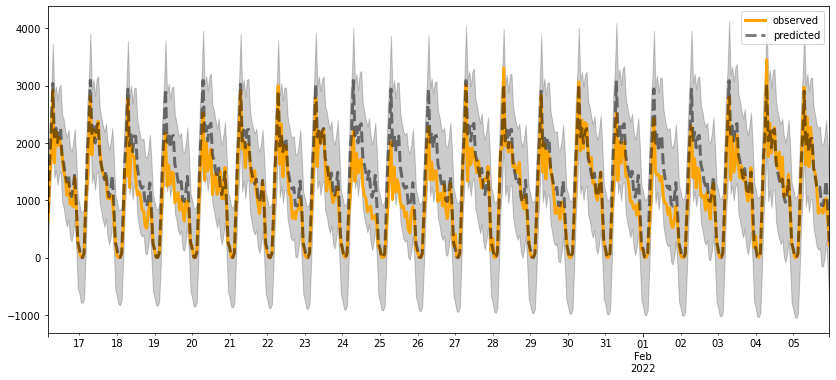

AIC: 369247.53583531006
MAE: 237.09928249957645


In [12]:
pred = fit.get_prediction(start=df_ts.index.values[0], end = df_ts.index.values[-1], dynamic=True)
pred_ci = pred.conf_int()
    
ax = df_ts.SFO.plot(figsize=(14,6), label='observed', linewidth=3, color = 'orange')
pred.predicted_mean.plot(ax=ax, alpha=0.5, label='predicted', linewidth=3, color='black', linestyle='--')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.legend()
plt.show()
    
error = mean_absolute_error(df_ts.SFO, pred.predicted_mean)
print(f'AIC: {fit.aic}')
print(f'MAE: {error}')

In [7]:
final_model = SARIMAX(df.SFO, order=(1, 0, 1), seasonal_order=(3, 1, 3, 24))
fitted_model = final_model.fit(disp=0)

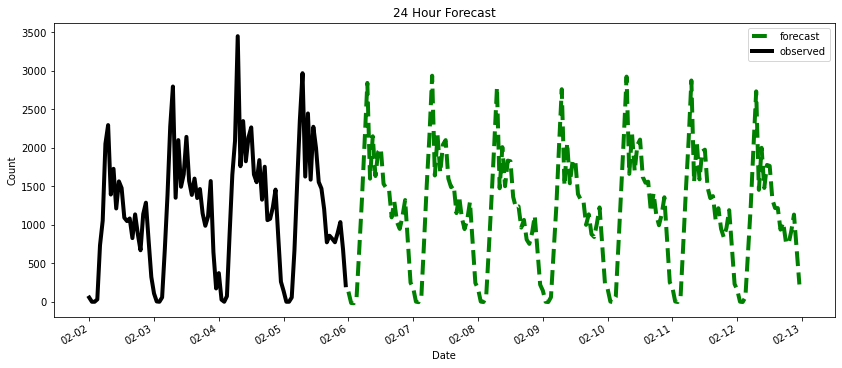

In [9]:
fig, ax = plt.subplots(figsize = (14, 6))
ax.plot(fitted_model.forecast(168), color = 'green', linewidth = 4, linestyle = '--', label='forecast')
ax.plot(df.SFO.loc['2022-02-02':], color = 'black', linewidth = 4, label = 'observed')
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_title('24 Hour Forecast')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
fig.autofmt_xdate()
ax.legend();